## Configuração do Ambiente e Carregamento dos Dados

Este bloco configura o ambiente, baixa o conjunto de dados e carrega o arquivo CSV em um DataFrame do pandas.

In [8]:
from google.colab import userdata
import os
import kagglehub

# Definindo as variáveis de ambiente
os.environ['KAGGLE_USERNAME'] = userdata.get('userName')
os.environ['KAGGLE_KEY'] = userdata.get('apiKey')

# Baixar o dataset usando o Kagglehub
kagglehub.dataset_download('mlg-ulb/creditcardfraud')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar os dados
dataset_dir = '/root/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3'
file_path = os.path.join(dataset_dir, 'creditcard.csv')
df = pd.read_csv(file_path)

# Verificar distribuição inicial das classes
print("Distribuição inicial das classes:")
print(df['Class'].value_counts(normalize=True))

Distribuição inicial das classes:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


## Visualização da Base de Dados Desbalanceada

Este bloco imprime as primeiras linhas da base de dados original e exibe a distribuição das classes antes do balanceamento.

Primeiras linhas da base de dados original (desbalanceada):
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137

<ipython-input-9-c17dfadae30a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Class', palette=['skyblue', 'salmon'])


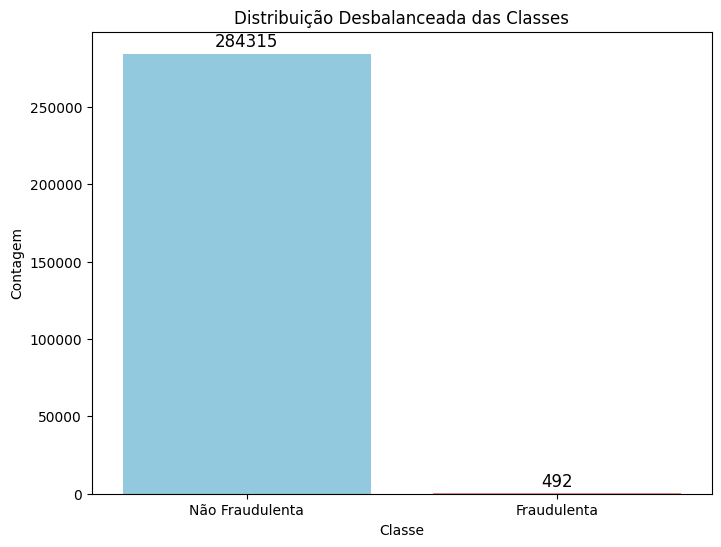

In [9]:
# Visualizar a base de dados desbalanceada
print("Primeiras linhas da base de dados original (desbalanceada):")
print(df.head())

# Visualizar a distribuição das classes na base desbalanceada
print("\nDistribuição das classes antes do balanceamento:")
print(df['Class'].value_counts(normalize=True))

# Gráfico da distribuição inicial das classes com números nas barras
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='Class', palette=['skyblue', 'salmon'])

# Adicionar os números nas barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Configurar o título e os rótulos
plt.title("Distribuição Desbalanceada das Classes")
plt.xlabel("Classe")
plt.ylabel("Contagem")
plt.xticks([0, 1], ['Não Fraudulenta', 'Fraudulenta'], rotation=0)
plt.show()

## Balanceamento dos Dados com Undersampling

Este bloco realiza o balanceamento dos dados, reduzindo a classe majoritária para o mesmo número de amostras da classe minoritária.


Distribuição das classes após balanceamento:
Class
0    0.5
1    0.5
Name: proportion, dtype: float64


<ipython-input-10-d12027be896c>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=balanced_df, x='Class', palette=['skyblue', 'salmon'])


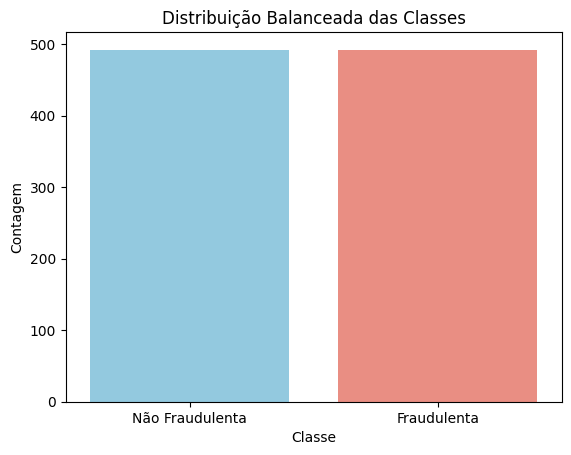

In [10]:
from sklearn.utils import shuffle

# Separar dados fraudulentos e não fraudulentos
fraud_df = df[df['Class'] == 1]
non_fraud_df = df[df['Class'] == 0]

# Fazer undersampling da classe majoritária (não fraudulentos)
non_fraud_sampled = non_fraud_df.sample(n=492, random_state=42)

# Combinar os dois DataFrames balanceados
balanced_df = pd.concat([fraud_df, non_fraud_sampled])

# Embaralhar o DataFrame balanceado
balanced_df = shuffle(balanced_df, random_state=42)

# Verificar a nova distribuição de classes
print("\nDistribuição das classes após balanceamento:")
print(balanced_df['Class'].value_counts(normalize=True))

# Visualizar a distribuição balanceada
sns.countplot(data=balanced_df, x='Class', palette=['skyblue', 'salmon'])
plt.title("Distribuição Balanceada das Classes")
plt.xlabel("Classe")
plt.ylabel("Contagem")
plt.xticks([0, 1], ['Não Fraudulenta', 'Fraudulenta'], rotation=0)
plt.show()

## Divisão dos Dados em Treino e Test

Este bloco divide o conjunto de dados balanceado em variáveis preditoras e alvo, e separa em conjuntos de treino e teste.

In [11]:
from sklearn.model_selection import train_test_split

# Dividir os dados em features (X) e target (y)
X = balanced_df.drop('Class', axis=1)
y = balanced_df['Class']

# Dividir o conjunto de dados balanceado em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

Tamanho do conjunto de treino: (787, 30)
Tamanho do conjunto de teste: (197, 30)


## Treinamento e Avaliação dos Modelos

Este bloco treina diferentes modelos de aprendizado de máquina no conjunto de treino balanceado e avalia os resultados no conjunto de teste.


Treinando e avaliando o modelo: Random Forest
Acurácia: 0.9492
Matriz de Confusão:
[[97  2]
 [ 8 90]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        99
           1       0.98      0.92      0.95        98

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197

AUC: 0.9793


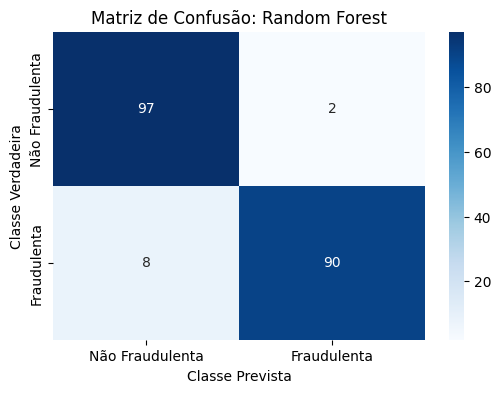


Treinando e avaliando o modelo: SVM
Acurácia: 0.5533
Matriz de Confusão:
[[51 48]
 [40 58]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.56      0.52      0.54        99
           1       0.55      0.59      0.57        98

    accuracy                           0.55       197
   macro avg       0.55      0.55      0.55       197
weighted avg       0.55      0.55      0.55       197

AUC: 0.5920


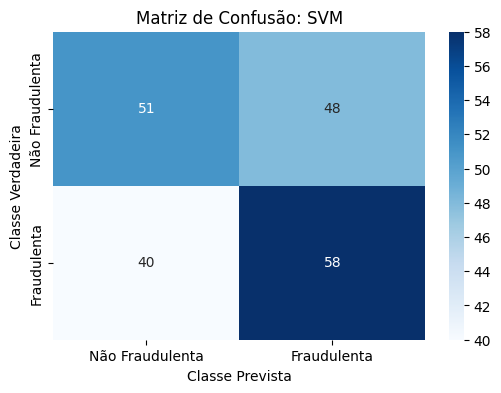


Treinando e avaliando o modelo: Logistic Regression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Acurácia: 0.9391
Matriz de Confusão:
[[94  5]
 [ 7 91]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        99
           1       0.95      0.93      0.94        98

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197

AUC: 0.9813


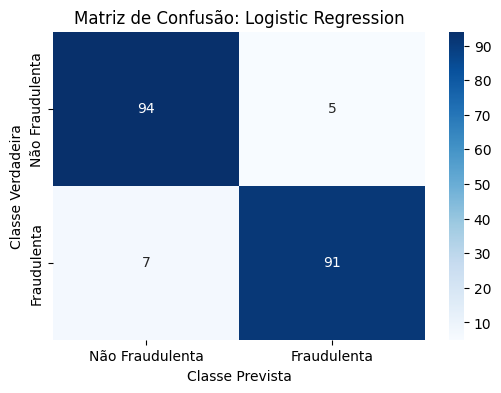


Treinando e avaliando o modelo: Naive Bayes
Acurácia: 0.8376
Matriz de Confusão:
[[97  2]
 [30 68]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.76      0.98      0.86        99
           1       0.97      0.69      0.81        98

    accuracy                           0.84       197
   macro avg       0.87      0.84      0.83       197
weighted avg       0.87      0.84      0.83       197

AUC: 0.9555


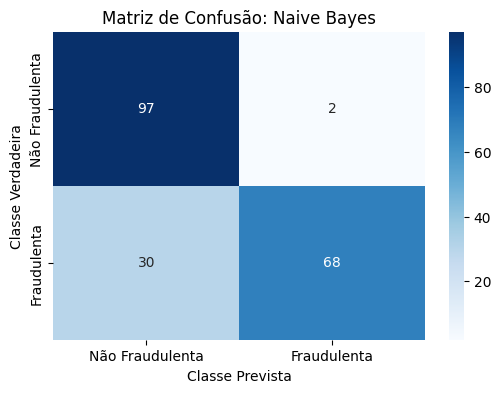


Treinando e avaliando o modelo: K-Nearest Neighbors
Acurácia: 0.5838
Matriz de Confusão:
[[63 36]
 [46 52]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.58      0.64      0.61        99
           1       0.59      0.53      0.56        98

    accuracy                           0.58       197
   macro avg       0.58      0.58      0.58       197
weighted avg       0.58      0.58      0.58       197

AUC: 0.6216


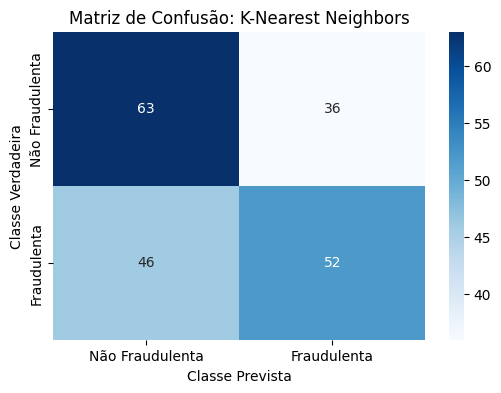

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import seaborn as sns

# Configurar modelos
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
}

results = {}

for name, model in models.items():
    print(f"\nTreinando e avaliando o modelo: {name}")
    # Treinar o modelo
    model.fit(X_train, y_train)

    # Fazer previsões no conjunto de teste
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Avaliar o modelo
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba) if y_proba is not None else "N/A"

    # Salvar os resultados
    results[name] = {
        "Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "Classification Report": class_report,
        "AUC Score": auc_score,
        "Predictions": y_pred,
    }

    # Exibir os resultados
    print(f"Acurácia: {accuracy:.4f}")
    print("Matriz de Confusão:")
    print(conf_matrix)
    print("Relatório de Classificação:")
    print(class_report)
    if y_proba is not None:
        print(f"AUC: {auc_score:.4f}")

    # Gráfico da Matriz de Confusão
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Fraudulenta', 'Fraudulenta'], yticklabels=['Não Fraudulenta', 'Fraudulenta'])
    plt.title(f"Matriz de Confusão: {name}")
    plt.xlabel("Classe Prevista")
    plt.ylabel("Classe Verdadeira")
    plt.show()

## Visualização dos Resultados

Este bloco gera gráficos para comparar a acurácia dos modelos e a distribuição de previsões para cada um deles.

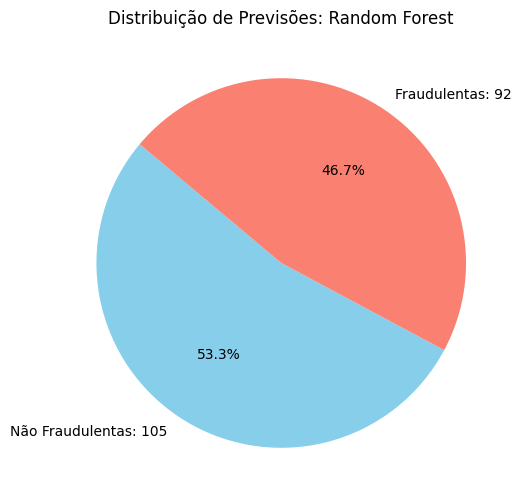

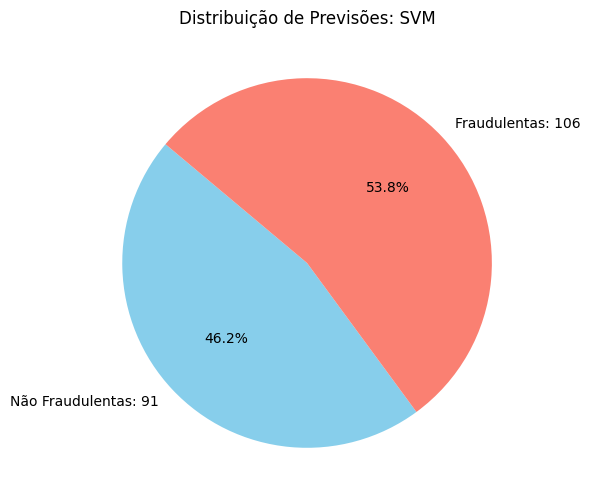

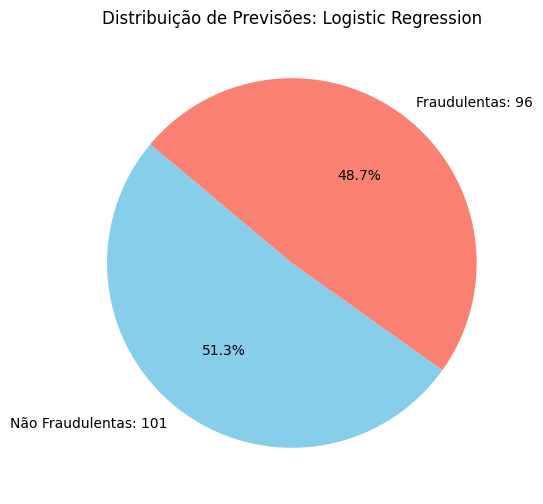

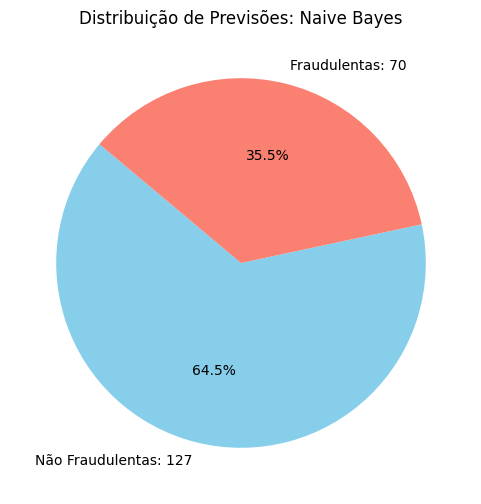

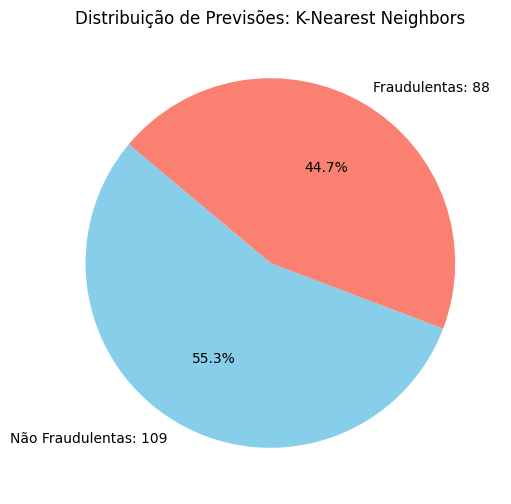

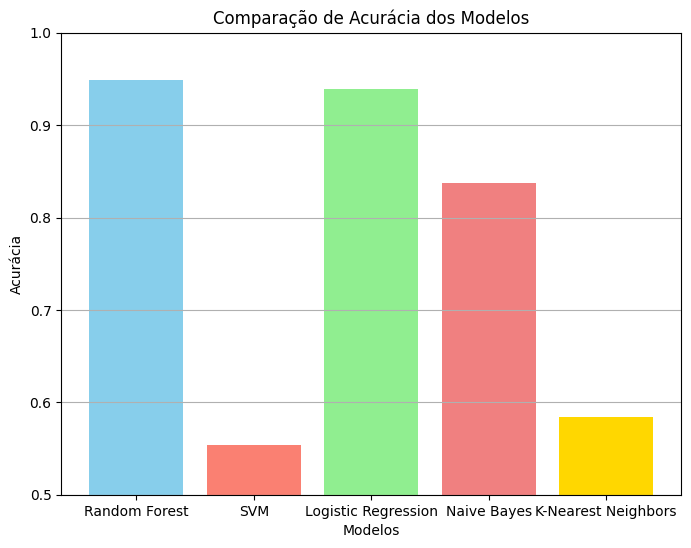

In [13]:
# Gráficos de pizza para previsões
for name, metrics in results.items():
    predicted_counts = pd.Series(metrics["Predictions"]).value_counts().sort_index()
    predicted_labels = ['Não Fraudulentas', 'Fraudulentas']
    plt.figure(figsize=(6, 6))
    predicted_counts.plot(
        kind='pie',
        labels=[f"{label}: {count}" for label, count in zip(predicted_labels, predicted_counts)],
        startangle=140,
        colors=['skyblue', 'salmon'],
        autopct='%1.1f%%'
    )
    plt.title(f'Distribuição de Previsões: {name}')
    plt.ylabel('')
    plt.show()

# Comparação de acurácias
accuracies = [results[model]["Accuracy"] for model in results]
model_names = list(results.keys())

plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['skyblue', 'salmon', 'lightgreen', 'lightcoral', 'gold'])
plt.title("Comparação de Acurácia dos Modelos")
plt.xlabel("Modelos")
plt.ylabel("Acurácia")
plt.ylim(0.5, 1.0)
plt.grid(axis='y')
plt.show()

## Curva ROC/AUC

Este bloco gera a curva ROC para cada modelo e calcula o AUC (Área sob a Curva) para facilitar a comparação.

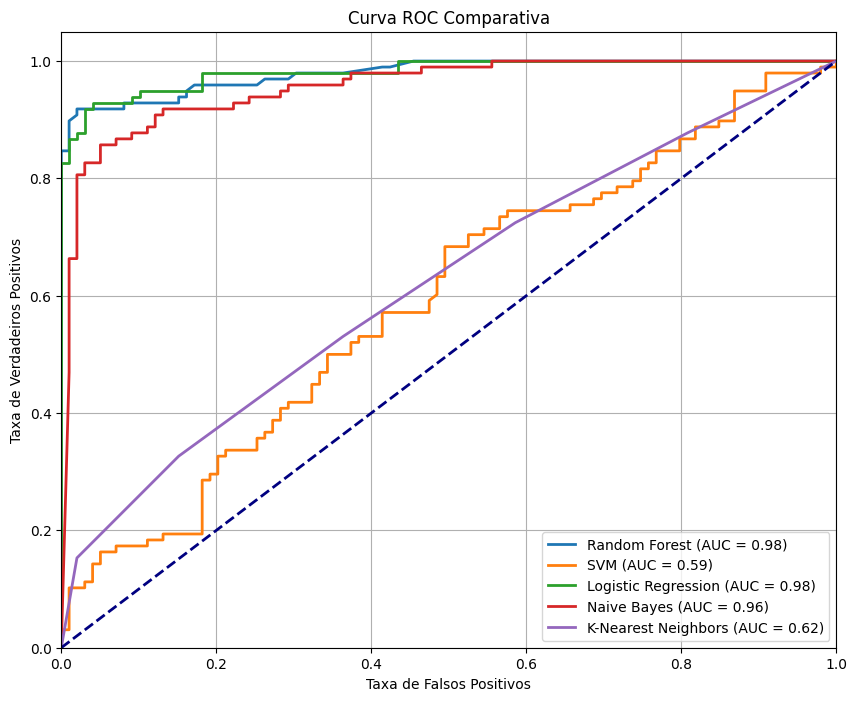

In [14]:
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {auc:.2f})")

# Linha de referência (classificador aleatório)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.title("Curva ROC Comparativa")
plt.legend(loc="lower right")
plt.grid()
plt.show()